In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

###1. Analysing, Preprocessing data

In [2]:
house_df_org = pd.read_csv('/content/drive/MyDrive/ml-data/house-prices-advanced-regression-techniques/train.csv')

In [3]:
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


####1-2. Null processing

In [4]:
isnull_series = house_df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


####1-3. log transformation about y

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


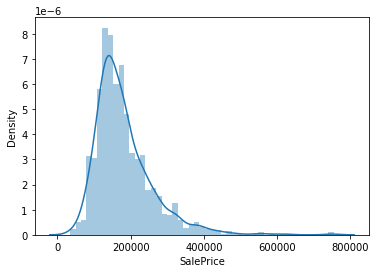

In [5]:
sns.distplot(house_df['SalePrice'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


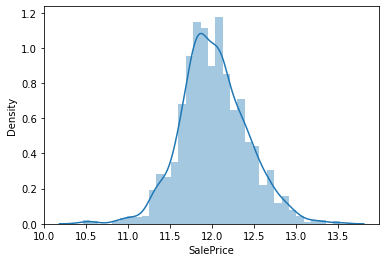

In [6]:
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [7]:
# Preprocessing 1 : log transformation
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Preprocessing 2 : drop columns s.t have a lot of nan vale 
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
# Preprocessing 3 : fill nan with mean value
house_df.fillna(house_df.mean(), inplace=True)

####1-4. one-hot-encoding

In [8]:
print(house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print(house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print(null_column_count)

print("========")
print(house_df_ohe.dtypes.value_counts())
house_df_ohe.head(5)

(1460, 75)
(1460, 271)
Series([], dtype: int64)
uint8      234
int64       33
float64      4
dtype: int64


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,12.247699,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,12.109016,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,12.317171,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,11.849405,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,12.429220,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### 2. Learning algorithms, by using LinearRegression

In [9]:
from sklearn.metrics import mean_squared_error

def get_rmse(model, X_test, y_test):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse) # == rmsle
  print("###",model.__class__.__name__, '- RMSE : ', np.round(rmse, 3))
  return rmse

def get_rmses(models, X_test, y_test):
  rmses = []
  for model in models:
    rmse = get_rmse(model, X_test, y_test)
    rmses.append(rmse)
  return rmses

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

y = house_df_ohe['SalePrice']
X = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=156)

# LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models, X_test, y_test)

### LinearRegression - RMSE :  0.132
### Ridge - RMSE :  0.128
### Lasso - RMSE :  0.176


[0.13189576579154205, 0.12750846334052995, 0.17628250556471403]

####2-2. check coefficients

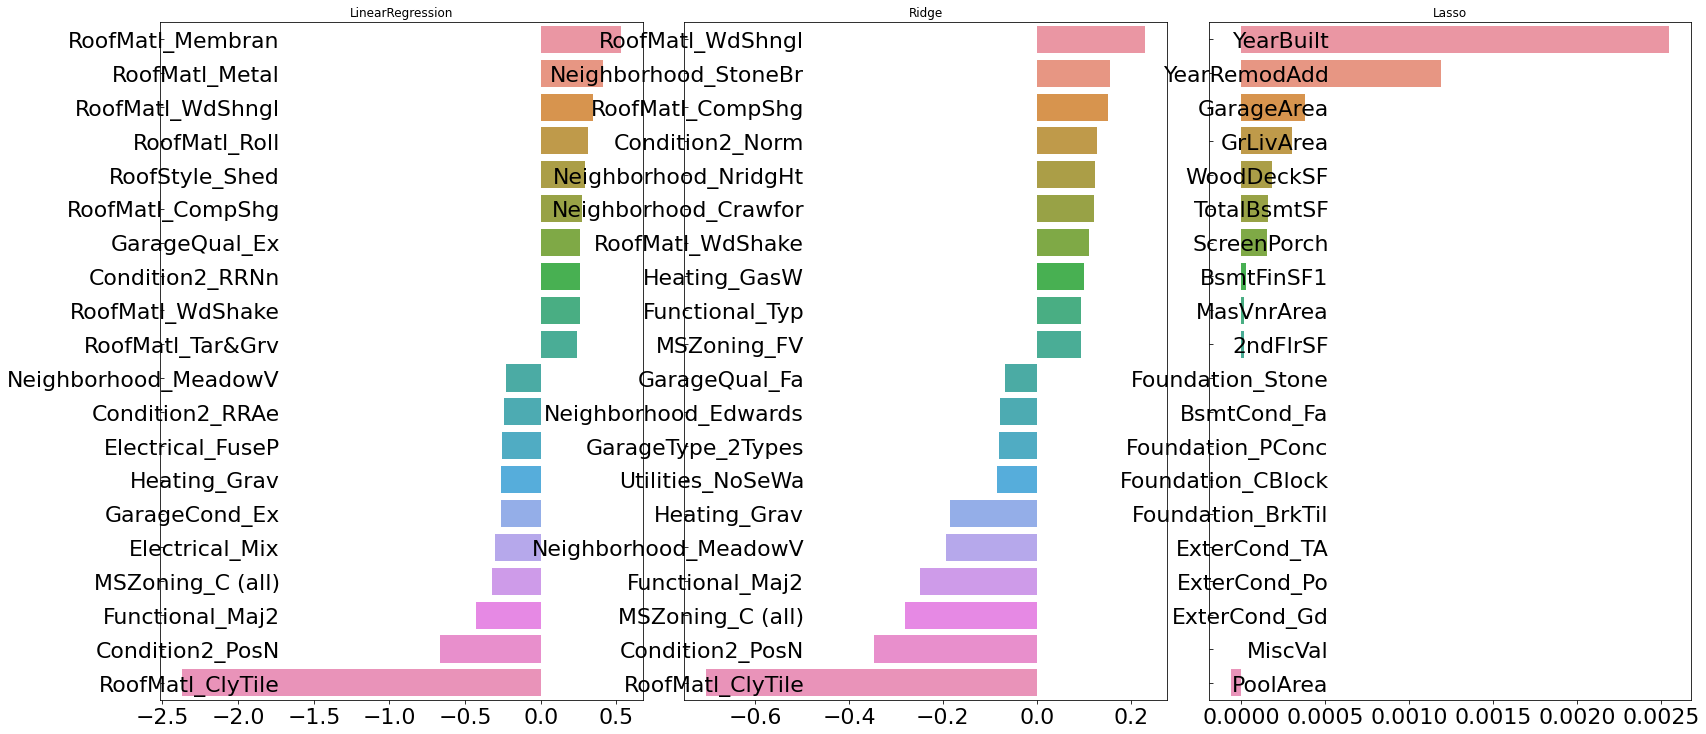

In [11]:
def get_top_bottom_coef(model, n=10):
  coef = pd.Series(model.coef_, index=X.columns)

  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

def visulize_coefficient(models):
  fig, axes = plt.subplots(figsize=(22,10), nrows=1, ncols=3)
  fig.tight_layout()
  for i_num, model in enumerate(models):
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    axes[i_num].set_title(model.__class__.__name__)
    axes[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axes[i_num].get_xticklabels() + axes[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axes[i_num])
  
models = [lr_reg, ridge_reg, lasso_reg]
visulize_coefficient(models)

In [12]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print("{0} RMSE LIST : {1}".format(model.__class__.__name__, np.round(rmse_list, 3)))
    print("{0} CV MEAN RMSE VALUE: {1}".format(model.__class__.__name__, np.round(rmse_avg, 3)))
    print("================")

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression RMSE LIST : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV MEAN RMSE VALUE: 0.155
Ridge RMSE LIST : [0.117 0.154 0.142 0.117 0.189]
Ridge CV MEAN RMSE VALUE: 0.144
Lasso RMSE LIST : [0.161 0.204 0.177 0.181 0.265]
Lasso CV MEAN RMSE VALUE: 0.198


####2-3. by using GridSearchCV, get best parameters

In [13]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv=5)
  grid_model.fit(X, y)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print("{0} 5 CV, BEST value : {1}, optimal param : {2}".format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
  return grid_model.best_estimator_

ridge_params = {
    'alpha':[0.05, 0.1, 1., 5., 8., 10., 12., 15., 20.],
}

lasso_params = {
    'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1., 5., 10.]
}

get_best_params(ridge_reg, ridge_params)
get_best_params(lasso_reg, lasso_params)

Ridge 5 CV, BEST value : 0.1418, optimal param : {'alpha': 12.0}
Lasso 5 CV, BEST value : 0.142, optimal param : {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### LinearRegression - RMSE :  0.132
### Ridge - RMSE :  0.124
### Lasso - RMSE :  0.12


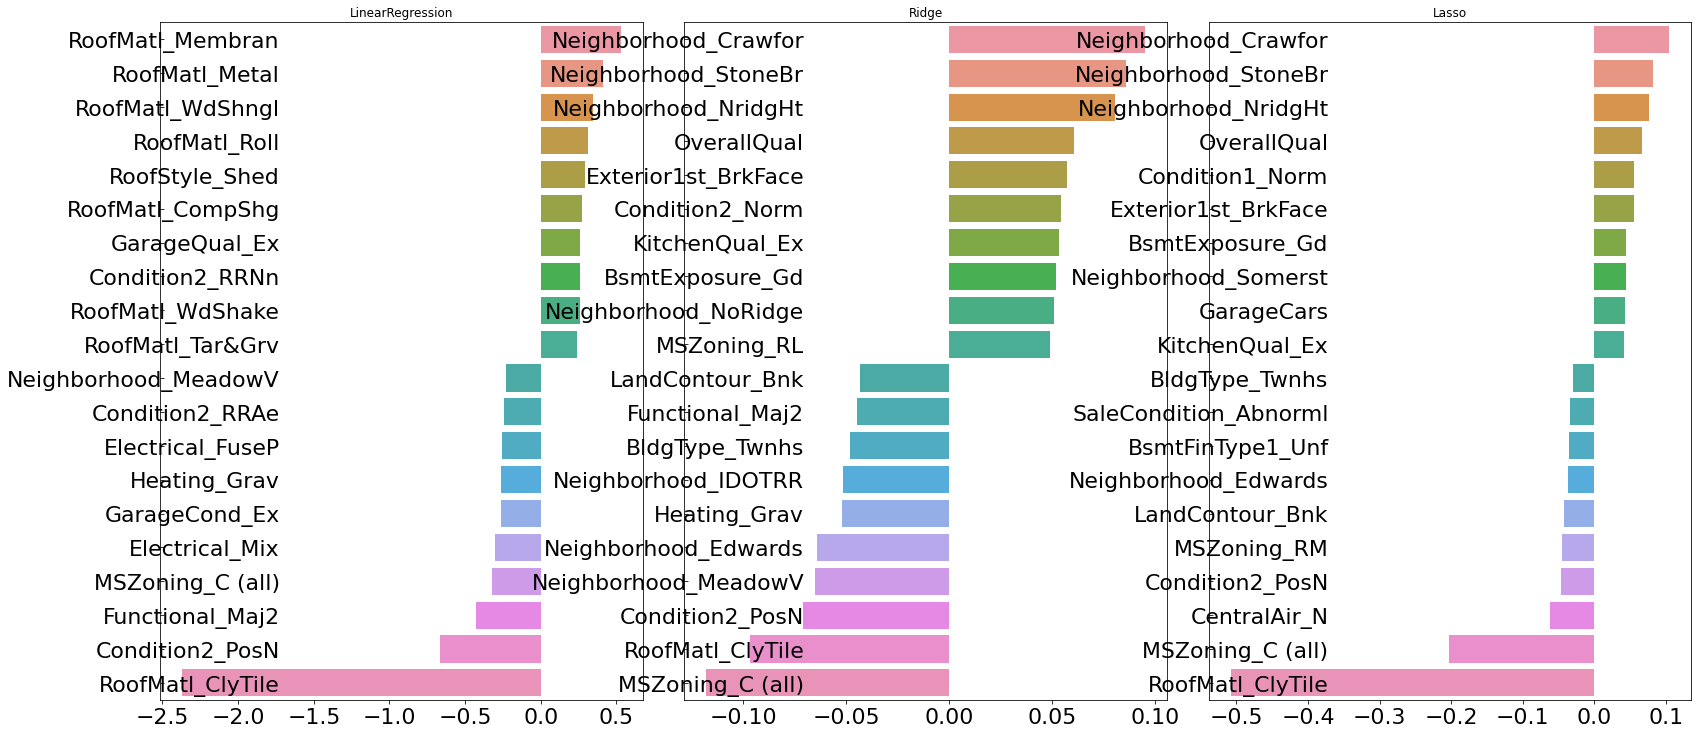

In [14]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models, X_test, y_test)
visulize_coefficient(models)

####2-4. log transform skew data

In [15]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features >  1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [16]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [17]:
house_df_ohe = pd.get_dummies(house_df)
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1., 5., 8. ,10., 12., 15., 20.]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1., 5., 10.]}
get_best_params(ridge_reg, ridge_params)
get_best_params(lasso_reg, lasso_params)

Ridge 5 CV, BEST value : 0.1275, optimal param : {'alpha': 10.0}
Lasso 5 CV, BEST value : 0.1252, optimal param : {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

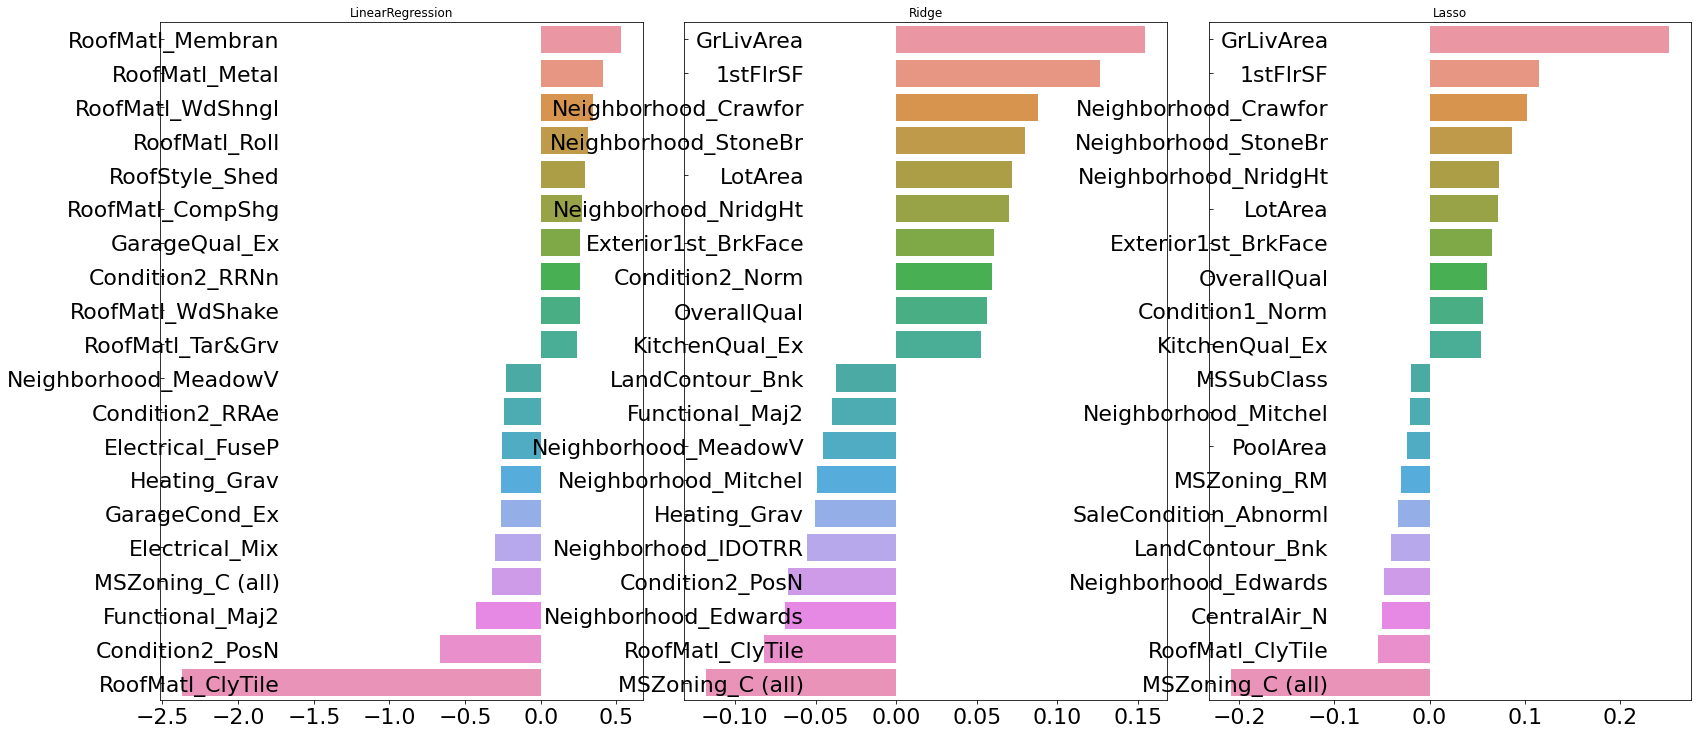

In [18]:
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
models = [lr_reg, ridge_reg, lasso_reg]
visulize_coefficient(models)

#### 2-5. kill enormal data

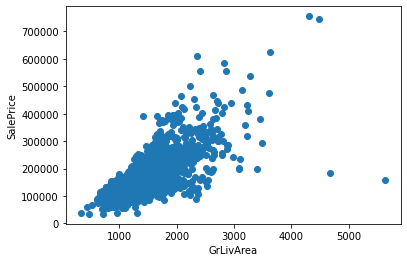

In [19]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")
plt.show()

In [20]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(300000)
outlier_index = house_df_ohe[cond1 & cond2].index
print(outlier_index)
house_df_ohe.drop(outlier_index, axis=0, inplace=True)

Int64Index([523, 1298], dtype='int64')


In [21]:
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1., 5., 8. ,10., 12., 15., 20.]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1., 5., 10.]}
get_best_params(ridge_reg, ridge_params)
get_best_params(lasso_reg, lasso_params)

Ridge 5 CV, BEST value : 0.1125, optimal param : {'alpha': 8.0}
Lasso 5 CV, BEST value : 0.1122, optimal param : {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

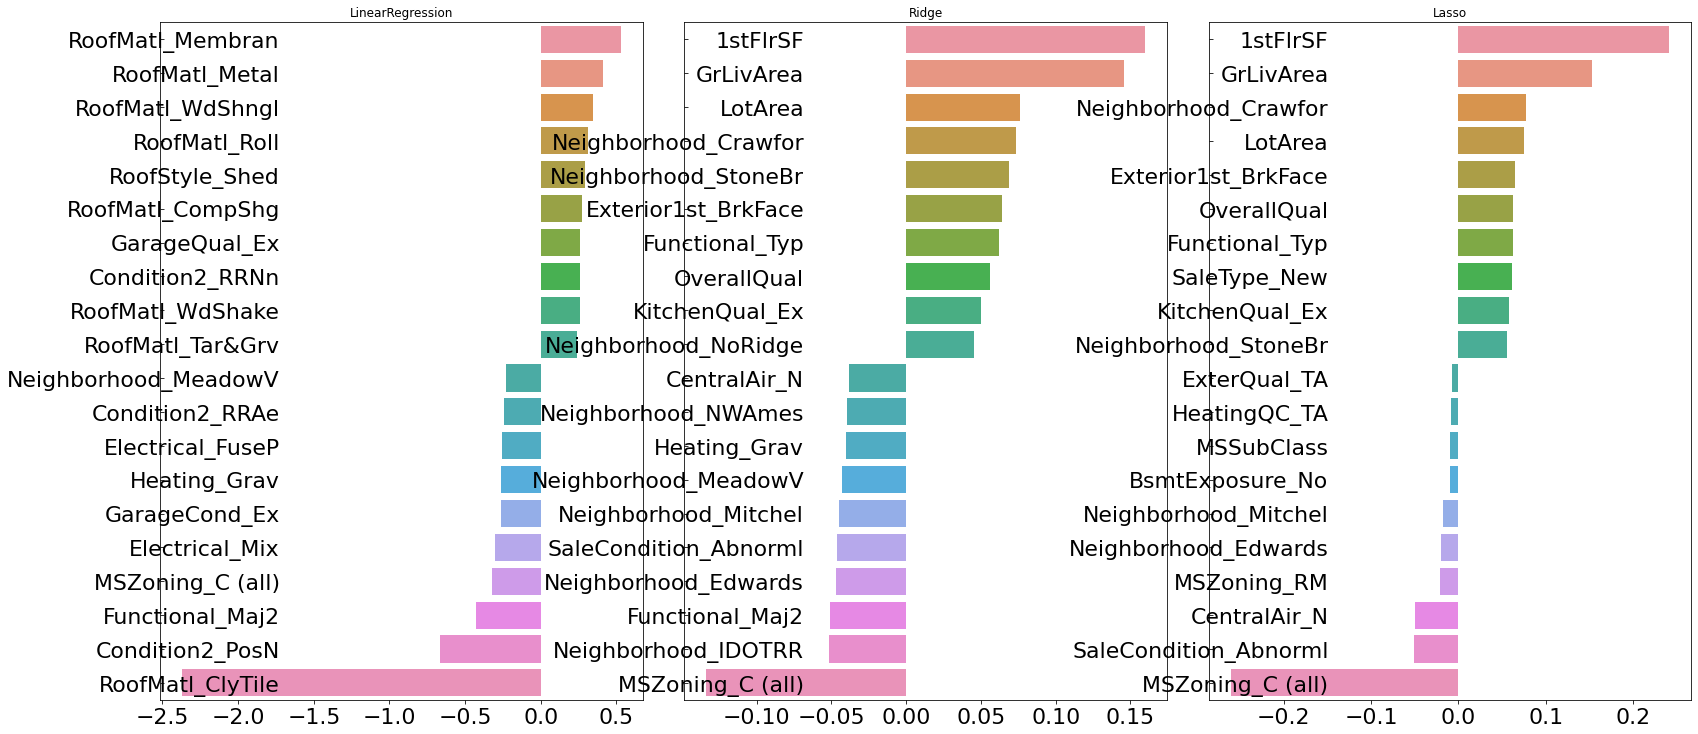

In [22]:
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
models = [lr_reg, ridge_reg, lasso_reg]
visulize_coefficient(models)

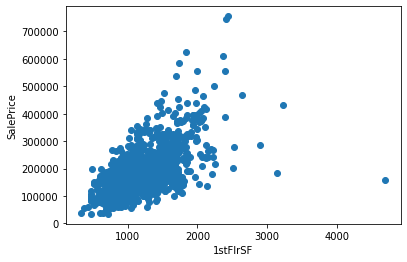

In [23]:
plt.scatter(x = house_df_org['1stFlrSF'], y = house_df_org['SalePrice'])
plt.ylabel("SalePrice")
plt.xlabel("1stFlrSF")
plt.show()

In [24]:
cond1 = house_df_ohe['1stFlrSF'] > np.log1p(3000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index
print(outlier_index)
print(house_df_ohe.shape)
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print(house_df_ohe.shape)

Int64Index([496], dtype='int64')
(1458, 271)
(1457, 271)


In [25]:
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1., 5., 8. ,10., 12., 15., 20.]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1., 5., 10.]}
get_best_params(ridge_reg, ridge_params)
get_best_params(lasso_reg, lasso_params)

Ridge 5 CV, BEST value : 0.1125, optimal param : {'alpha': 8.0}
Lasso 5 CV, BEST value : 0.1122, optimal param : {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

###By using Regression Tree

In [26]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg_best = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV, BEST value : 0.116, optimal param : {'n_estimators': 1000}


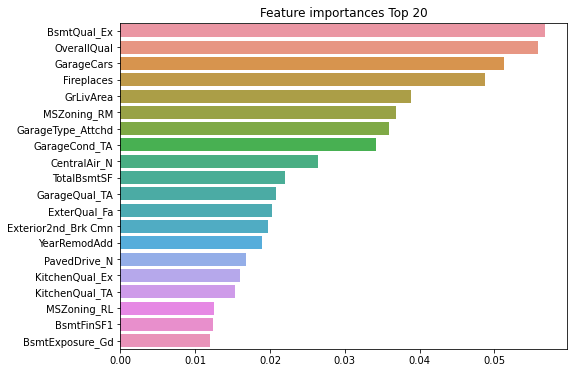

In [27]:
features_index = xgb_reg_best.feature_importances_
features_index = pd.Series(features_index, index=X_train.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title("Feature importances Top 20")
sns.barplot(x=features_index, y = features_index.index)
plt.show()

In [28]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_reg_best = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV, BEST value : 0.1169, optimal param : {'n_estimators': 1000}


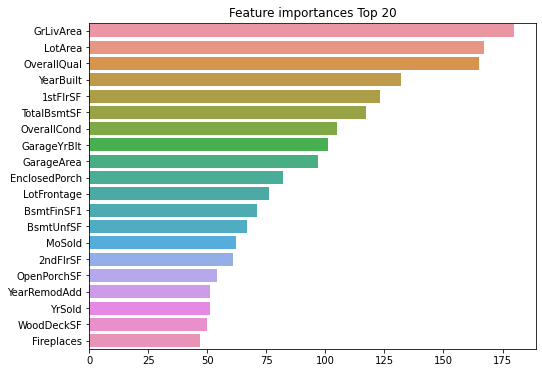

In [29]:
features_index = lgbm_reg_best.feature_importances_
features_index = pd.Series(features_index, index=X_train.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title("Feature importances Top 20")
sns.barplot(x=features_index, y = features_index.index)
plt.show()

### Stacking

In [48]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=False)
  train_data = np.zeros((X_train.shape[0], 1))
  test_data = np.zeros((X_test.shape[0], n_folds))

  for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_te = X_train[test_index]

    model.fit(X_tr, y_tr)
    train_data[test_index] = model.predict(X_te).reshape(-1, 1)
    test_data[:, i] = model.predict(X_test)
  test_data_mean = np.mean(test_data, axis=1).reshape(-1, 1)
  return train_data, test_data_mean

In [53]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

In [54]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test,lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(rmse)

0.0973364461664872
